# Topic Classification

Editor link for evaluation: https://colab.research.google.com/drive/1nsAyYCZaxPrfu7nYumJlpedQSidzPeYX?usp=sharing

Description:

As part of the requirements to pass this course you will be asked to do an analysis of a test set. During the lab sessions, you will familiarise yourself with the tools to use.

As part of the final assignment you are also to describe your analyses in a poster that further details:

- description of the tasks at hand;

- description of the data used (train and test: data collection strategy, statistics of the datasets, source of data, references to the datasets used);

- a description and motivation for your approach(es) (with links to the theory presented in the lectures and from relevant literature), which includes description of preprocessing steps, parameters, features, and feature representations used;

- discussion and analysis of the obtained results (both quantitative and qualitative analyses with examples of erroneous predictions);

- conclusions and limitations of your approach and what could be done to improve it should you have more time;

- links to your source code / your experiments  (zip file);

- a short paragraph stating how you divided the work in your group (who did what).

Your poster should be 1 page (pdf), including a short paragraph how you divided the work is compulsory. Without such a paragraph, the report is not graded!!!

## Install/import Libraries

In [ ]:
# uncomment if simpletransformer is not installed
!pip install simpletransformers

In [ ]:
# import libraries
import pandas as pd
import nltk
import numpy as np
import sklearn
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

## Load in and clean the Datasets/ Data exploration

#### Sports (Scraped dataset)

The initial performance of the transformer models was not satisfactory. On closer inspection, I surmised that this was highly likely because the text in the 20 Newsgroups dataset did not sufficiently resemble the test set. Since obtaining a suitable dataset online had proven difficult, I decided to procure my own data by way of datascraping reddit.

The initial performance with non-scraped sports dataset:

ALBERT
                  
                  precision    recall  f1-score   support

    book            0.75      1.00      0.86         6
    movie           0.40      0.67      0.50         6
    sports          0.00      0.00      0.00         6

    accuracy                            0.56        18
    macro avg       0.38      0.56      0.45        18
    weighted avg    0.38      0.56      0.45        18

MPNet
    
                  precision    recall  f1-score   support

    book            0.86      1.00      0.92         6
    movie           0.50      0.83      0.62         6
    sports          1.00      0.17      0.29         6

    accuracy                            0.67        18
    macro avg       0.79      0.67      0.61        18
    weighted avg    0.79      0.67      0.61        18

BERT
              
              precision    recall  f1-score   support

    book              0.75      1.00      0.86         6
    movie             0.44      0.67      0.53         6
    sports            1.00      0.17      0.29         6

    accuracy                              0.61        18
    macro avg         0.73      0.61      0.56        18
    weighted avg      0.73      0.61      0.56        18

DistilBERT
              
                    precision    recall  f1-score   support

    book              0.75      1.00      0.86         6
    movie             0.50      0.67      0.57         6
    sports            1.00      0.33      0.50         6

    accuracy                              0.67        18
    macro avg         0.75      0.67      0.64        18
    weighted avg      0.75      0.67      0.64        18

-----------------------------------------------------------
Results from scraped dataset

ALBERT
              
              precision    recall  f1-score   support

    book       0.86      1.00      0.92         6
    movie       1.00      0.83      0.91         6
    sports       1.00      1.00      1.00         6

    accuracy                           0.94        18
    macro avg       0.95      0.94      0.94        18
    weighted avg       0.95      0.94      0.94        18

MPNet
              
                precision    recall  f1-score   support

    book          0.86      1.00      0.92         6
    movie         1.00      0.83      0.91         6
    sports        1.00      1.00      1.00         6

    accuracy                           0.94        18
    macro avg     0.95      0.94      0.94        18
    weighted avg  0.95      0.94      0.94        18

BERT
    
                precision    recall  f1-score   support

    book            0.75      1.00      0.86         6
    movie           0.44      0.67      0.53         6
    sports          1.00      0.17      0.29         6

    accuracy                           0.61        18
    macro avg       0.73      0.61      0.56        18
    weighted avg    0.73      0.61      0.56        18

DistilBERT
              
                precision    recall  f1-score   support

    book        0.86      1.00      0.92         6
    movie       1.00      0.83      0.91         6
    sports       1.00      1.00      1.00         6

    accuracy                           0.94        18
    macro avg       0.95      0.94      0.94        18
    weighted avg       0.95      0.94      0.94        18

The datascraping methods we're adapted from:
https://www.geeksforgeeks.org/scraping-reddit-using-python/

and:

https://asyncpraw.readthedocs.io/en/stable/getting_started/quick_start.html

In [ ]:
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 7.8 MB/s eta 0:00:00


In [ ]:
! pip install PRAW

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
import asyncpraw
import asyncio
import praw
import re
from asyncpraw.models import MoreComments
nltk.download('punkt_tab')


reddit = asyncpraw.Reddit(
    client_id = "OqcMcI7DmsBQHE_dAMPiqA",
    client_secret = "ulNqpj0vMKvck0fowcP9IMAaA2jOWQ",
    user_agent = "SOScraper",
)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
async def get_relevant_comments(reddit: asyncpraw.Reddit, submission_ID: str, comment_limit=None):
  print("initializing comment extraction...")
  try:
    submission = await reddit.submission(f"{submission_ID}")
    cleaned_text = []

    # get comments from submission
    comments = submission.comments
    for top_level_comment in comments:
      if isinstance(top_level_comment, MoreComments):
        continue
      comment_text = top_level_comment.body.lower()
      # print(comment_text)
      # tokenize the scraped comments
      sentences = nltk.sent_tokenize(comment_text)
      for sentence in sentences:
        # print(f"sentence level token: {sentence}")
        cleaned_sent = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
        # print(f"cleaned sentence: {cleaned_sent}")
        cleaned_text.append(cleaned_sent)

  except Exception as e:
    print(f"An error occurred in auxillary function: {e}")

  return cleaned_text


In [ ]:
async def get_relevant_submission(reddit: asyncpraw.Reddit, subreddit_name: str, keyword: str, limit: int):
    subreddit = await reddit.subreddit(subreddit_name)
    relevant_submissions = []
    count = 0
    relevant_comments = []
    try:
      async for submission in subreddit.hot(limit=None):
          if count < limit:
            # get the title for each submission
            title = submission.title.lower()
            # print(f"fetching title: {title}")

            # Tokenize the cleaned title
            tokens = nltk.word_tokenize(title)
            # print(f"tokenized title: {tokens}")

            # Check if the keyword is in the title
            if keyword.lower() in tokens:
              print(f"keyword {keyword} found")

            # if keyword.lower in title:
              clean_title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
              relevant_comments.append(clean_title)
              # print(f"cleaned title: {clean_title}")
              relevant_submissions.append(submission.title.lower())
              print(f"Submission {count + 1}: {submission.title}")
              print(f"Submission URL: https://www.reddit.com/r/{subreddit_name}/comments/{submission}/")
              # print(f"Submission Score: {submission.score}")
              # print(f"Submission Author: {submission.author}")
              # print(f"Submission ID: {submission.id}")
              print("_" * 50)
              try:
                # print(f"function input: {reddit}, {submission}, {2}")
                submission_text = await get_relevant_comments(reddit, submission)
                relevant_comments.extend(submission_text)
              except Exception as e:
                print(f"An error occurred in calling the auxillary function {e}")
              print(f"End of comment extraction for submission: '{submission.title}'")
              print("_" * 50)

              # iterate the submission count
              count += 1
            else:
              # print(f"keyword {keyword} not found")
              continue
          else:
            print(f"Limit of {limit} reached")
            break
    except Exception as e:
      print(f"An error occurred in the main function: {e}")
    return relevant_submissions, relevant_comments

I identified some keyword from the test set that the models could build topic association with, these keywords are used as input parameters to find relevand submissions, from which all the top-layer comments are extracted to provide training sentences for the models.

In [ ]:
# Extracting the text data from various subreddits

# football subreddit
submissions_goal = await get_relevant_submission(reddit, 'football', 'goal', 20)
submissions_team = await get_relevant_submission(reddit, 'football', 'team', 20)
submissions_coach = await get_relevant_submission(reddit, 'football', 'coach', 20)
submissions_last_minute =  await get_relevant_submission(reddit, 'football', "last-minute", 20)

# PremierLeague subreddit
submissions_goal_2 = await get_relevant_submission(reddit, 'PremierLeague', 'goal', 20)
submissions_team_2 = await get_relevant_submission(reddit, 'PremierLeague', 'team', 20)
submissions_coach_2 = await get_relevant_submission(reddit, 'PremierLeague', 'coach', 20)

# worldcup subreddit
submissions_goal_3 = await get_relevant_submission(reddit, 'worldcup', "goal", 20)
submissions_team_3 = await get_relevant_submission(reddit, 'worldcup', "team", 20)
submissions_coach_3 = await get_relevant_submission(reddit, 'worldcup', "coach", 20)

# chamionsleague subreddit
submissions_goal_4 = await get_relevant_submission(reddit, 'championsleague', "goal", 20)
submissions_team_4 = await get_relevant_submission(reddit, 'championsleague', "team", 100)
submissions_coach_4 = await get_relevant_submission(reddit, 'championsleague', "coach", 20)



keyword goal found
Submission 1: Messi: Favorite goal was vs. Man Utd in UCL final '09
Submission URL: https://www.reddit.com/r/football/comments/1ktm8o0/
__________________________________________________
initializing comment extraction...
End of comment extraction for submission: 'Messi: Favorite goal was vs. Man Utd in UCL final '09'
__________________________________________________
keyword goal found
Submission 2: Spurs are 17th in PL With a Positive Goal Difference... Has it Ever Happened Before in Top Flight Without Point Deductions?
Submission URL: https://www.reddit.com/r/football/comments/1ksht0n/
__________________________________________________
initializing comment extraction...
End of comment extraction for submission: 'Spurs are 17th in PL With a Positive Goal Difference... Has it Ever Happened Before in Top Flight Without Point Deductions?'
__________________________________________________
keyword goal found
Submission 3: Watkins breaks Aston Villa goal record in win o

In [ ]:
print(f"sentences extracted: {len(submissions_coach_4[1])}")

sentences extracted: 246


In [ ]:
submissions_coach_4[1]

['inzaghi is the worst coach ive ever seen',
 'fellow fans this is a friendly reminder to please follow the ruleshttpswwwredditcomrchampionsleagueaboutrules and reddiquettehttpssupportreddithelpcomhcenusarticles205926439reddiquette',
 'join us on discordhttpsdiscordggfootball\n\n\ni am a bot and this action was performed automatically',
 'please contact the moderators of this subredditmessagecomposetorchampionsleague if you have any questions or concerns',
 '',
 'the worst coach ever got to a ucl final twice',
 'must be a crap competition',
 '2 finals in 3 years',
 'you know how insane that is',
 'i would love to be in your shoes',
 'my club barcelona hasnt been in the final for a decade',
 'i hate inter with passion but clearly you have some of the worst take they still beat barcabayern to make it here ',
 'and still managed to be up for the serie a title until the very end',
 'ok',
 'give it a rest you bellend',
 'he got you to a champions league final and you lost out on serie a by 

In [ ]:
data = [submissions_goal[1],
        submissions_team[1],
        submissions_coach[1],
        submissions_last_minute[1],
        submissions_goal_2[1],
        submissions_team_2[1],
        submissions_coach_2[1],
        submissions_goal_3[1],
        submissions_team_3[1],
        submissions_coach_3[1],
        submissions_goal_4[1],
        submissions_team_4[1],
        submissions_coach_4[1]]

all_scraped_text = []

for text in data:
  all_scraped_text.extend(text)
print(f"Total number of scraped sentences: {len(all_scraped_text)}")
# print(all_scraped_text)

keywords = ['goal', 'team', 'coach']

# further data cleaning
for sentence in all_scraped_text:
  if len(sentence) < 50:
    all_scraped_text.remove(sentence)
    # add back in if it contains keyword
    if any(keyword in sentence for keyword in keywords):
      # print(f"Removed sentence: {sentence}")
      all_scraped_text.append(sentence)
print(f"Total number of scraped sentences: {len(all_scraped_text)}")
print(all_scraped_text)

Total number of scraped sentences: 8645
Total number of scraped sentences: 6268
['messi favorite goal was vs man utd in ucl final 09', 'etoos 10 was pretty great as well in that game', 'has to be the highlight of his career to score against the biggest and best football club in the world and holders of the champions league', 'he also idolised scholes and fought with xavi and iniesta to get his shirt after the game', 'as a liverpool supporter same boss same', 'unreal side tbf', 'iniesta was the best player on the pitch that night ', 'ronaldo doesnt approve', 'it was a very good header goal for a very short man messi', ' hanging in the air\n\n ball reverses direction\n\n looping parabola into the corner across the keeper\n\n messi not known for headers and heads a winnerclincher in the biggest club cup final', 'that said etoos initial goal was the key to the entire outcome he unlocked a solid defence with a virtuoso goal out of nothing', 'spurs are 17th in pl with a positive goal differe

In [ ]:
# Save the scraped dataset
scraped_data = []
for sentence in all_scraped_text:
  scraped_data.append({'text': sentence, 'label': 'sports'})

# create a DF from the list of dicts
sports_df_scraped = pd.DataFrame(scraped_data)

# Define an output file path
output_file_path = '/content/sports.csv'

# Save the DataFrame to a CSV file
sports_df_scraped.to_csv(output_file_path, index=False)

print(f"Scraped sports dataset saved to: {output_file_path}")


Scraped sports dataset saved to: /content/sports.csv


#### Sports

Taken from the 20 newsgroups dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# load in the specific sports related categories
categories = ['rec.sport.hockey', 'rec.sport.baseball']

# remove headers footers and quotes
newsgroup_sport = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [ ]:
Counter(newsgroup_sport.target)

Counter({np.int64(0): 597, np.int64(1): 600})

So we have about 1200 documents with sports label that need to be split into sentences.

In [ ]:
# example
print(newsgroup_sport.data[0])



The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)



In [ ]:
nltk.download('punkt_tab')
# split data into sentences and put them into a usable dataframe
sport_sentences = []
for document in newsgroup_sport.data:
  # split the document into sentences
  sport_sentences.extend(nltk.sent_tokenize(document))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
print(f"now we have {len(sport_sentences)} sentences, each of which can be labelled as sports.")
print(f"Example: {sport_sentences[0]}")
print(f"Example length: {len(sport_sentences[0])}")

now we have 11352 sentences, each of which can be labelled as sports.
Example: 

The tribe will be in town from April 16 to the 19th.
Example length: 54


In [ ]:
# use regex to remove all special characters from the text documents

cleaned_sentences_sport = []
for text in sport_sentences:
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_sentences_sport.append(cleaned_text)

In [ ]:
# Create the "sports" Dataframe
sports_df = pd.DataFrame({'text': sport_sentences, 'label': 'sports'})
sports_df.head()

,text,label
0,\n\nThe tribe will be in town from April 16 to...,sports
1,There are ALWAYS tickets available!,sports
2,"(Though they are playing Toronto,\nand many To...",sports
3,"Either way, I seriously\ndoubt they will sell ...",sports
4,This game would have been great as part of a d...,sports


#### Books

While I could conveniently source the sklearn datasets for the sports examples the same was not the case for Books nor Movies, I had to search for those independently on the internet.

The book examples we're sourced from here: https://www.kaggle.com/datasets/shrutimehta/amazon-book-reviews-webscraped?select=Reviews.csv


In [ ]:
# !unzip /content/amazon-book-reviews-webscraped.zip is what I'm actually doing but for convenience it was renamed
# after downloading it from kaggle and renaming it uzip the file to access the reviews
!unzip /content/books.zip

Archive:  /content/books.zip
  inflating: Input.csv               
  inflating: Reviews.csv             
  inflating: negative-words.csv      
  inflating: positive-words.csv      


In [ ]:
# specifying the path to the reviews
path = '/content/Reviews.csv'
book_data = []
try:
  # Load up the csv
  with open(path, 'r', encoding='iso-8859-1') as f:
    for line in f:
      if len(line) > 50: # only get texts that are long enough and thus contain information
        book_data.append(line)

  print(f"Succesfully loaded {len(book_data)} lines of text")


except FileNotFoundError:
  print("File not found")

except Exception as e:
  print(f"An error occurred: {e}")

Succesfully loaded 4892 lines of text


In [ ]:
# Example of data
book_data[0]

'"Good. It IS a page turner. You can read this book in one day, two at the most, and the plot drives the whole book. The unreliable narrators (there are two besides the main character) are as unlikable as they are unreliable, and there isn\'t a nice male in the book. Entirely plot driven; the characters are paper thin. You can figure out who-dunnit by the middle of the book. The ending is weak. I can\'t imagine what all the fuss is about, except that it is quick and there are lots of twists and turns, and you can\'t trust anyone to tell the truth."\n'

In [ ]:
# split the text into sentences
book_sentences = []
for documents in book_data:
  book_sentences.extend(nltk.sent_tokenize(documents))


In [ ]:
# sentence examples
print(f"Now there are {len(book_sentences)} sentences which can be labled with book")
print(f"Sentence example:{book_sentences[6]}")
print(f"Sentence example length:{len(book_sentences[6])}")

Now there are 26118 sentences which can be labled with book
Sentence example:The ending is weak.
Sentence example length:19


In [ ]:
# Clean the sentences
cleaned_sentences_book = []
for text in book_sentences:
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_sentences_book.append(cleaned_text)

In [ ]:
# load it into a dataframe
books_df = pd.DataFrame({'text': cleaned_sentences_book, 'label': 'book'})
books_df.head()

,text,label
0,Good,book
1,It IS a page turner,book
2,You can read this book in one day two at the m...,book
3,The unreliable narrators there are two besides...,book
4,Entirely plot driven the characters are paper ...,book


#### Movies

Now finally to process the movies dataset this one was sourced from Kaggle as well. https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/input

although the source was used for sentiment analysis the dataset will perfectly suit the purpose of topic classification as well.

In [ ]:
# unzip the movies dataset to gain access to the csv
!unzip /content/movies.zip

Archive:  /content/movies.zip
  inflating: IMDB Dataset.csv        


In [ ]:
movie_path = '/content/IMDB Dataset.csv'
movie_data = []

try:
  with open(movie_path, 'r', encoding='iso-8859-1') as f:
    for line in f:
      if len(line) > 50: # only get texts that are long enough and thus contain information
        movie_data.append(line)

except FileNotFoundError:
  print("File not found")

except Exception as e:
  print(f"An error occurred: {e}")

In [ ]:
# print example of movie_review
movie_data[0]

'"One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the 

In [ ]:
# split text into sentences
movie_sentences = []
for documents in movie_data:
  movie_sentences.extend(nltk.sent_tokenize(documents))

In [ ]:
movie_sentences[0]

'"One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked.'

In [ ]:
# clean the sentences in the set
cleaned_sentences_movie = []
for text in movie_sentences:
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_sentences_movie.append(cleaned_text)

In [ ]:
cleaned_sentences_movie[0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked'

In [ ]:
print(f"Now there are {len(cleaned_sentences_movie)} sentences which can be labled with movies")
print(f"Sentence example: {cleaned_sentences_movie[0]}")
print(f"Sentence example length: {len(cleaned_sentences_movie[0])}")

Now there are 576512 sentences which can be labled with movies
Sentence example: One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked
Sentence example length: 94


In [ ]:
# load into dataframe
movies_df = pd.DataFrame({'text': cleaned_sentences_movie, 'label': 'movie'})
movies_df.head()

,text,label
0,One of the other reviewers has mentioned that ...,movie
1,They are right as this is exactly what happene...,movie
2,Trust me this is not a show for the faint hear...,movie
3,This show pulls no punches with regards to dru...,movie
4,Its is hardcore in the classic use of the word...,movie


## Synthesize the training/test set

To address potential class imbalance and manage training time effectively, we will construct a balanced dataset by undersampling each topic category. This involves taking a random sample of equal size from the 'Books', 'Movies', and 'Sports' datasets. These equal-sized samples are then concatenated to form a unified, balanced dataset. Finally, this combined dataset is randomly shuffled and partitioned into training and testing sets using an 80/20 split, ensuring that the distribution of topics is maintained proportionally in both sets through stratified splitting. This approach ensures that the model is not biased towards topics with larger initial datasets and that evaluation is performed on a representative sample of each category.

I will also consider sentences with less than 50 characters as not relevant as there will likely not be enough information in the sentence to train the model off of. This will improve training effectivenss by increasing data quality and ensuring that potentially noisy or uninformative entries are not considered.

In [ ]:
# Define minimum length for relevant sentences
minimum_relevant_length = 50

# Drop all indices in the dataset where the length of the text is smaller than the minimum relevant length
books_df_filtered = books_df.drop(books_df.index[books_df['text'].str.len() <= minimum_relevant_length])
movies_df_filtered = movies_df.drop(movies_df.index[movies_df['text'].str.len() <= minimum_relevant_length])
sports_df_filtered = sports_df.drop(sports_df.index[sports_df['text'].str.len() <= minimum_relevant_length])

NameError: name 'books_df' is not defined

In [ ]:
print(f" There are now {len(books_df_filtered)} sentences labled with book")
print(f" There are now {len(movies_df_filtered)} sentences labled with movies")
print(f" There are now {len(sports_df_filtered)} sentences labled with sports")

In [ ]:
books_df_filtered.head()

In [ ]:
movies_df_filtered.head()

In [ ]:
sports_df_filtered.head()

In [ ]:
# get the minimum dataset size
min_size = min(len(books_df_filtered), len(movies_df_filtered), len(sports_df_filtered))

# undersample each dataset to the minimum
books_df_sampled = books_df_filtered.sample(n=min_size, random_state=42)
movies_df_sampled = movies_df_filtered.sample(n=min_size, random_state=42)
sports_df_sampled = sports_df_filtered.sample(n=min_size, random_state=42)

print(f"Sample sizes: Books={len(books_df_sampled)}, Movies={len(movies_df_sampled)}, Sports={len(sports_df_sampled)}")

# Combine the datasets
combined_df = pd.concat([books_df_sampled, movies_df_sampled, sports_df_sampled])
print(f"Combined dataset size: {len(combined_df)}")

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

Labels need to be encoded into integers because most transformer models use a classification head that outputs logits over a fixed number of classes, where each class is represented by an index. The original "label" can then be used to decode model predictions back to readable topics.

In [ ]:
# transform the labels to integers using LabelEncoder
le = LabelEncoder()
combined_df['label_enc'] = le.fit_transform(combined_df['label'])

In [ ]:
# Split into training and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['label_enc'])

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
# simpletransformers expects a 'labels' column so I will rename the label and label_enc columns
train_df = train_df.rename(columns={'label': 'topic_name', 'label_enc': 'labels'})
test_df = test_df.rename(columns={'label': 'topic_name', 'label_enc': 'labels'})

In [ ]:
train_df.head()

Here we take 10% of the training set to make a validation set

In [ ]:
# create validation set
train_df, eval_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['labels'])

In [ ]:
# calculate the number of steps per epoch
train_steps = len(train_df) // 32
train_steps

## ALBERT (A Lite Bert)

In [ ]:
# configure the model arguments
albert_model_args = ClassificationArgs()

# hyperparameters arguments
albert_model_args.num_train_epochs= 10 # number of training epochs
albert_model_args.learning_rate = 4e-5 # learning rate
albert_model_args.train_batch_size = 32 # batch size for training
albert_model_args.eval_batch_size = 32 # batch size for evaluation

# storing results
albert_model_args.reprocess_input_data = True # reprocess the input data
albert_model_args.overwrite_output_dir = True # overwrite the output directory
albert_model_args.output_dir = '/content/' # directory to save the model
albert_model_args.max_seq_length = 64 # maximum sequence length

# early stopping to prevent overfitting
albert_model_args.use_early_stopping = True
albert_model_args.early_stopping_delta = 0.01
albert_model_args.early_stopping_metric = "eval_loss"
albert_model_args.early_stopping_metric_minimize = True
albert_model_args.early_stopping_patience = 2
albert_model_args.evaluate_during_training = True
albert_model_args.evaluate_during_training_steps = train_steps // 2

In [ ]:
# initialize ALBERT the model
albert_model = ClassificationModel(
    'albert', 'albert-base-v2', num_labels=3, args=albert_model_args, use_cuda=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
print("Initializing ALBERT model...")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(eval_df)}")
print(f"Number of test samples: {len(test_df)}")
print("starting model training...")

# Pass the training DataFrame and the validation DataFrame
_, albert_history = albert_model.train_model(
    train_df,
    eval_df=eval_df,
)

Initializing ALBERT model...
Number of training samples: 15741
Number of validation samples: 1750
Number of test samples: 4373
starting model training...


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


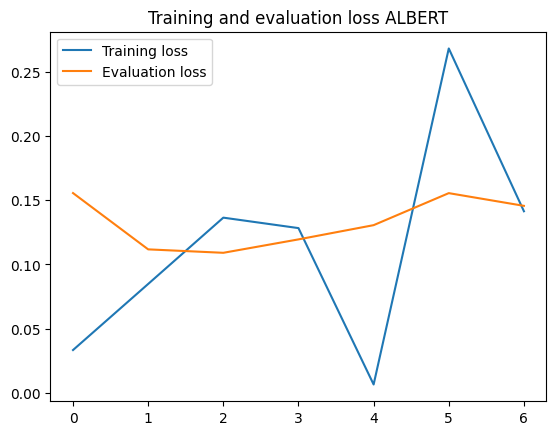

In [ ]:
# Training and evaluation loss
train_loss = albert_history['train_loss']
eval_loss = albert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss ALBERT')
plt.legend()

In [ ]:
# Evaluate model on test set
albert_result, albert_model_outputs, albert_wrong_predictions = albert_model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make prediction and add them to test dataset
albert_predicted, albert_predicted_probs = albert_model.predict(test_df['text'].tolist())
test_df['ALBERT_pred'] = albert_predicted

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df.head()

,text,topic_name,labels,ALBERT_pred
4604,I was astounded that an American studio could ...,movie,1,1
3869,Note 2: I maybe have harped on this a bit in t...,sports,2,2
13508,The writer has infused life into the most wret...,book,0,0
18958,Note to all mad scientists everywhere if youre...,movie,1,1
2105,\nLook how long the Maple Leafs and Nordiques ...,sports,2,2


In [ ]:
albert_result

{'mcc': np.float64(0.9471669065088175),
 'acc': 0.9645552252458267,
 'eval_loss': 0.14471409168012822}

In [ ]:
# Result of the ALBERT model on the train_test_split
print(classification_report(test_df['labels'], test_df['ALBERT_pred'], target_names=['books', 'movies', 'sports']))

              precision    recall  f1-score   support

       books       0.93      0.97      0.95      1457
      movies       0.97      0.93      0.95      1458
      sports       1.00      1.00      1.00      1458

    accuracy                           0.96      4373
   macro avg       0.97      0.96      0.96      4373
weighted avg       0.97      0.96      0.96      4373



## MPNet

Stands for (masked permuted pre-training), aiming to get the best of both BERT and XLNET. Levereges BERT's efficacy at understanding token context and simultaneously is good at capturing dependencies across positions.

In [ ]:
# Configure the model arguments
mpnet_model_args = ClassificationArgs()

# Hyperparam Args
mpnet_model_args.num_train_epochs = 10 # number of training epochs
mpnet_model_args.learning_rate = 4e-5  # learing rate
mpnet_model_args.train_batch_size = 32
mpnet_model_args.eval_batch_size = 32

# storing results
mpnet_model_args.reprocess_input_data = True # reprocess the input data
mpnet_model_args.overwrite_output_dir = True # overwrite the output directory
mpnet_model_args.output_dir = '/content/' # directory to save the model
mpnet_model_args.max_seq_length = 64 # maximum sequence length

# Early stop condidition
mpnet_model_args.use_early_stopping = True
mpnet_model_args.early_stopping_delta = 0.01
mpnet_model_args.early_stopping_metric = "eval_loss"
mpnet_model_args.early_stopping_metric_minimize = True
mpnet_model_args.early_stopping_patience = 2
mpnet_model_args.evaluate_during_training = True
mpnet_model_args.evaluate_during_training_steps = train_steps // 2

In [ ]:
# initialize the model
mpnet_model = ClassificationModel(
    'mpnet', 'microsoft/mpnet-base',
    num_labels=3,
    args=mpnet_model_args, use_cuda=True)

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Initializing MPNet model...")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(eval_df)}")
print(f"Number of test samples: {len(test_df)}")
print("starting model training...")

_, mpnet_history = mpnet_model.train_model(
    train_df,
    eval_df=eval_df,
)

Initializing MPNet model...
Number of training samples: 15741
Number of validation samples: 1750
Number of test samples: 4373
starting model training...


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


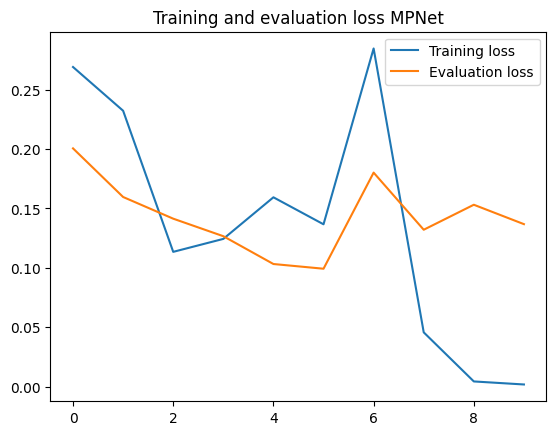

In [ ]:
# Training and evaluation loss
train_loss = mpnet_history['train_loss']
eval_loss = mpnet_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss MPNet')
plt.legend()

In [ ]:
# Evaluate the model
mpnet_results, mpnet_model_ouptuts, mpnet_wrong_predictions = mpnet_model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make predictions and add them to the test dataset
mpnet_predicted, mpnet_predicted_probs = mpnet_model.predict(test_df['text'].tolist())
test_df['MPNet_pred'] = mpnet_predicted

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df.head()

,text,topic_name,labels,ALBERT_pred,MPNet_pred
4604,I was astounded that an American studio could ...,movie,1,1,1
3869,Note 2: I maybe have harped on this a bit in t...,sports,2,2,2
13508,The writer has infused life into the most wret...,book,0,0,0
18958,Note to all mad scientists everywhere if youre...,movie,1,1,1
2105,\nLook how long the Maple Leafs and Nordiques ...,sports,2,2,2


In [ ]:
mpnet_results

{'mcc': np.float64(0.9602925319392991),
 'acc': 0.973473587925909,
 'eval_loss': 0.12069069694584902}

In [ ]:
print(classification_report(test_df['labels'], test_df['MPNet_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.97      0.95      0.96      1457
       movie       0.95      0.97      0.96      1458
      sports       1.00      1.00      1.00      1458

    accuracy                           0.97      4373
   macro avg       0.97      0.97      0.97      4373
weighted avg       0.97      0.97      0.97      4373



## BERT

Since both transformer models are improvements on BERT it makes sense to see the performance of BERT on this Dataset as well.

In [ ]:
# BERT will use these args
bert_model_args = ClassificationArgs()

# Hyperparam Args
bert_model_args.num_train_epochs = 10 # number of training epochs
bert_model_args.learning_rate = 4e-5  # learing rate
bert_model_args.train_batch_size = 32
bert_model_args.eval_batch_size = 32

# storing results
bert_model_args.reprocess_input_data = True # reprocess the input data
bert_model_args.overwrite_output_dir = True # overwrite the output directory
bert_model_args.output_dir = '/content/' # directory to save the model
bert_model_args.max_seq_length = 64 # maximum sequence length

# Early stop condidition
bert_model_args.use_early_stopping = True
bert_model_args.early_stopping_delta = 0.01
bert_model_args.early_stopping_metric = "eval_loss"
bert_model_args.early_stopping_metric_minimize = True
bert_model_args.early_stopping_patience = 2
bert_model_args.evaluate_during_training = True
bert_model_args.evaluate_during_training_steps = train_steps // 2

In [ ]:

# Initialize the model
bert_model = ClassificationModel(
    'bert', 'bert-base-cased',
    num_labels=3,
    args=bert_model_args,
    use_cuda=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Initializing BERT model...")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(eval_df)}")
print(f"Number of test samples: {len(test_df)}")
print("starting model training...")

_, bert_history = bert_model.train_model(
    train_df,
    eval_df=eval_df,
)

Initializing BERT model...
Number of training samples: 15741
Number of validation samples: 1750
Number of test samples: 4373
starting model training...


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


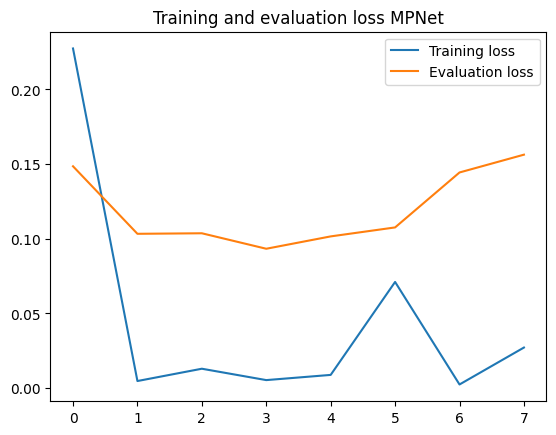

In [ ]:
# Training and evaluation loss
train_loss = bert_history['train_loss']
eval_loss = bert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss MPNet')
plt.legend()

In [ ]:
# Evaluate
bert_results, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make predictions and add them to test_df
bert_predictions, bert_predicted_probs = bert_model.predict(test_df['text'].tolist())
test_df['BERT_pred'] = bert_predictions

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df.head()

,text,topic_name,labels,ALBERT_pred,MPNet_pred,BERT_pred
4604,I was astounded that an American studio could ...,movie,1,1,1,1
3869,Note 2: I maybe have harped on this a bit in t...,sports,2,2,2,2
13508,The writer has infused life into the most wret...,book,0,0,0,0
18958,Note to all mad scientists everywhere if youre...,movie,1,1,1,1
2105,\nLook how long the Maple Leafs and Nordiques ...,sports,2,2,2,2


In [ ]:
bert_results

{'mcc': np.float64(0.9501836842040476),
 'acc': 0.9666133089412303,
 'eval_loss': 0.1475115598975613}

In [ ]:
print(classification_report(test_df['labels'], test_df['BERT_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.97      0.93      0.95      1457
       movie       0.93      0.97      0.95      1458
      sports       1.00      1.00      1.00      1458

    accuracy                           0.97      4373
   macro avg       0.97      0.97      0.97      4373
weighted avg       0.97      0.97      0.97      4373



## DistilBERT

Considering the small sample size of the final_test_set it is worth including distilbert. Though it's performance is generally slightly lower than the full BERT on large datasets, it's reduced size can make it more suitable for finetuning on smaller datasets as it has less parameters to overfit.

In [ ]:
# distilbert will use these args
distilbert_model_args = ClassificationArgs()

# Hyperparam Args
distilbert_model_args.num_train_epochs = 10 # number of training epochs
distilbert_model_args.learning_rate = 4e-5  # learing rate
distilbert_model_args.train_batch_size = 32
distilbert_model_args.eval_batch_size = 32

# storing results
distilbert_model_args.reprocess_input_data = True # reprocess the input data
distilbert_model_args.overwrite_output_dir = True # overwrite the output directory
distilbert_model_args.output_dir = '/content/' # directory to save the model
distilbert_model_args.max_seq_length = 64 # maximum sequence length

# Early stop condidition
distilbert_model_args.use_early_stopping = True
distilbert_model_args.early_stopping_delta = 0.01
distilbert_model_args.early_stopping_metric = "eval_loss"
distilbert_model_args.early_stopping_metric_minimize = True
distilbert_model_args.early_stopping_patience = 2
distilbert_model_args.evaluate_during_training = True
distilbert_model_args.evaluate_during_training_steps = train_steps // 2

In [ ]:
# initialize model
distilbert_model = ClassificationModel(
    'distilbert', 'distilbert-base-uncased',
    num_labels=3,
    args=distilbert_model_args,
    use_cuda=True
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
print("Initializing DistilBERT model...")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(eval_df)}")
print(f"Number of test samples: {len(test_df)}")
print("starting model training...")

_, distilbert_history = distilbert_model.train_model(
    train_df,
    eval_df=eval_df,
)

Initializing DistilBERT model...
Number of training samples: 15741
Number of validation samples: 1750
Number of test samples: 4373
starting model training...


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/492 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


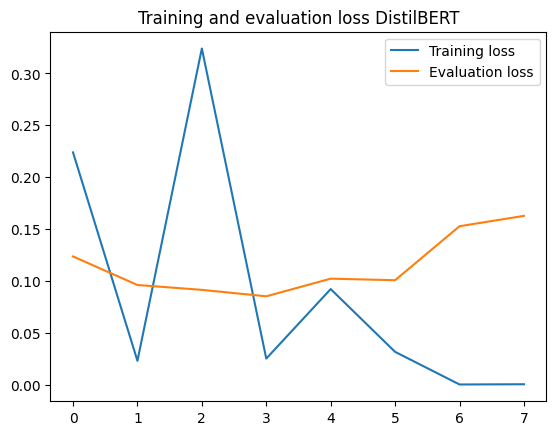

In [ ]:
# plot
train_loss = distilbert_history['train_loss']
eval_loss = distilbert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss DistilBERT')
plt.legend()

In [ ]:
# evaluate on test_df
distilbert_results, distilbert_model_outputs, distilbert_wrong_predictions = distilbert_model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# predictions
distilbert_predictions, distilbert_predicted_probs = distilbert_model.predict(test_df['text'].tolist())
test_df['DistilBERT_pred'] = distilbert_predictions

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
distilbert_results

{'mcc': np.float64(0.9532420308388903),
 'acc': 0.9686713926366339,
 'eval_loss': 0.13810660466968155}

In [ ]:
print(classification_report(test_df['labels'], test_df['DistilBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.94      0.97      0.95      1457
       movie       0.97      0.93      0.95      1458
      sports       1.00      1.00      1.00      1458

    accuracy                           0.97      4373
   macro avg       0.97      0.97      0.97      4373
weighted avg       0.97      0.97      0.97      4373



## Testing the models on the final test set

The initial evaluation on the preliminary test set offered early insights into the performance and characteristics of each model, and confirmed that the experimental setup was correct. We will now assess the models on the dedicated test set provided for the assignment.

In [ ]:
# Load in the test set.
test_path = '/content/sentiment-topic-test.tsv'
final_test_df = pd.read_csv(test_path, sep='\t')

In [ ]:
final_test_df['labels'] = le.fit_transform(final_test_df['topic'])
final_test_df = final_test_df.rename(columns={'sentence': 'text'})

In [ ]:
# Clean the sentences using the same regex as before
final_test_df['text'] = [re.sub(r'[^a-zA-Z0-9\s]', '', text) for text in final_test_df['text']]

In [ ]:
final_test_df.head(20)

,sentence_id,text,sentiment,topic,labels,ALBERT_pred,MPNet_pred,BERT_pred,DistilBERT_pred
0,0,The stadium was alive with the roar of the cro...,positive,sports,2,1,2,1,1
1,1,That lastminute goal had me jumping out of my ...,positive,sports,2,0,1,1,1
2,2,I couldnt put the book down it swept me into a...,positive,book,0,0,0,0,0
3,3,The story had its moments though some parts fe...,neutral,book,0,0,0,0,0
4,4,I enjoyed the way the timelines shifted even i...,neutral,book,0,0,0,0,0
5,5,Every time I watch this movie I notice somethi...,positive,movie,1,1,1,1,1
6,6,The movie was a wild ride from start to finish...,positive,movie,1,1,1,1,0
7,7,Honestly the team just fell apart in the secon...,negative,sports,2,1,2,1,1
8,8,No surprise therethe coach rested a few player...,neutral,sports,2,1,1,1,1
9,9,The trailer was decent giving you a taste with...,neutral,movie,1,1,1,1,1


In [ ]:
# Evaluate for all models
albert_results, albert_model_outputs, albert_wrong_predictions = albert_model.eval_model(final_test_df, acc=sklearn.metrics.accuracy_score)
mpnet_results, mpnet_model_ouptuts, mpnet_wrong_predictions = mpnet_model.eval_model(final_test_df, acc=sklearn.metrics.accuracy_score)
bert_results, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(final_test_df, acc=sklearn.metrics.accuracy_score)
distilbert_results, distilbert_model_outputs, distilbert_wrong_predictions = distilbert_model.eval_model(final_test_df, acc=sklearn.metrics.accuracy_score)

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# Make predictions and add them to the final_test_df
albert_predictions, albert_predicted_probs = albert_model.predict(final_test_df['text'].tolist())
final_test_df['ALBERT_pred'] = albert_predictions

mpnet_predictions, mpnet_predicted_probs = mpnet_model.predict(final_test_df['text'].tolist())
final_test_df['MPNet_pred'] = mpnet_predictions

bert_predictions, bert_predicted_probs = bert_model.predict(final_test_df['text'].tolist())
final_test_df['BERT_pred'] = bert_predictions

distilbert_predictions, distilbert_predicted_probs = distilbert_model.predict(final_test_df['text'].tolist())
final_test_df['DistilBERT_pred'] = distilbert_predictions

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
final_test_df.head(-1)

,sentence_id,text,sentiment,topic,labels,ALBERT_pred,MPNet_pred,BERT_pred,DistilBERT_pred
0,0,The stadium was alive with the roar of the cro...,positive,sports,2,1,2,1,1
1,1,That lastminute goal had me jumping out of my ...,positive,sports,2,0,1,1,1
2,2,I couldnt put the book down it swept me into a...,positive,book,0,0,0,0,0
3,3,The story had its moments though some parts fe...,neutral,book,0,0,0,0,0
4,4,I enjoyed the way the timelines shifted even i...,neutral,book,0,0,0,0,0
5,5,Every time I watch this movie I notice somethi...,positive,movie,1,1,1,1,1
6,6,The movie was a wild ride from start to finish...,positive,movie,1,1,1,1,0
7,7,Honestly the team just fell apart in the secon...,negative,sports,2,1,2,1,1
8,8,No surprise therethe coach rested a few player...,neutral,sports,2,1,1,1,1
9,9,The trailer was decent giving you a taste with...,neutral,movie,1,1,1,1,1


In [ ]:
print(f"results for bert: {bert_results}")
print(f"results for albert: {albert_results}")
print(f"results for mpnet: {mpnet_results}")
print(f"results for distilbert: {distilbert_results}")

results for bert: {'mcc': np.float64(0.3872983346207417), 'acc': 0.5555555555555556, 'eval_loss': 3.7882635593414307}
results for albert: {'mcc': np.float64(0.4841229182759271), 'acc': 0.6111111111111112, 'eval_loss': 2.7580015659332275}
results for mpnet: {'mcc': np.float64(0.6893819875457112), 'acc': 0.7777777777777778, 'eval_loss': 1.015538215637207}
results for distilbert: {'mcc': np.float64(0.3849001794597505), 'acc': 0.5555555555555556, 'eval_loss': 2.59049654006958}


In [ ]:
print("ALBERT")
print(classification_report(final_test_df['labels'], final_test_df['ALBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

print("MPNet")
print(classification_report(final_test_df['labels'], final_test_df['MPNet_pred'], target_names = ['book', 'movie', 'sports'] ))

print("BERT")
print(classification_report(final_test_df['labels'], final_test_df['BERT_pred'], target_names = ['book', 'movie', 'sports'] ))

print("DistilBERT")
print(classification_report(final_test_df['labels'], final_test_df['DistilBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

AlBERT
              precision    recall  f1-score   support

        book       0.75      1.00      0.86         6
       movie       0.50      0.83      0.62         6
      sports       0.00      0.00      0.00         6

    accuracy                           0.61        18
   macro avg       0.42      0.61      0.49        18
weighted avg       0.42      0.61      0.49        18

MPNet
              precision    recall  f1-score   support

        book       0.86      1.00      0.92         6
       movie       0.62      0.83      0.71         6
      sports       1.00      0.50      0.67         6

    accuracy                           0.78        18
   macro avg       0.83      0.78      0.77        18
weighted avg       0.83      0.78      0.77        18

BERT
              precision    recall  f1-score   support

        book       0.75      1.00      0.86         6
       movie       0.40      0.67      0.50         6
      sports       0.00      0.00      0.00         6

  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Retraining the models
Using the "sports" dataset that was scraped from reddit should improve performance on sports classification. The scraped dataset was gathered by targeting keywords that were relevant to and containend in the test set.



### Re-synthesis of training set

In [ ]:
print(f" There are now {len(books_df_filtered)} sentences labled with book")
print(f" There are now {len(movies_df_filtered)} sentences labled with movies")
print(f" There are now {len(sports_df_filtered)} sentences labled with sports")
print(f" There are now {len(sports_df_scraped)} sentences labled with sports from a scraped dataset")

 There are now 17573 sentences labled with book
 There are now 415194 sentences labled with movies
 There are now 7288 sentences labled with sports
 There are now 6552 sentences labled with sports from a scraped dataset


In [ ]:
books_df_filtered.head()

,text,label
2,You can read this book in one day two at the m...,book
3,The unreliable narrators there are two besides...,book
5,You can figure out whodunnit by the middle of ...,book
7,I cant imagine what all the fuss is about exce...,book
8,There are no words for how much I loathed this...,book


In [ ]:
movies_df_filtered.head()

,text,label
0,One of the other reviewers has mentioned that ...,movie
1,They are right as this is exactly what happene...,movie
2,Trust me this is not a show for the faint hear...,movie
3,This show pulls no punches with regards to dru...,movie
4,Its is hardcore in the classic use of the word...,movie


In [ ]:
sports_df_filtered.head()

,text,label
0,\n\nThe tribe will be in town from April 16 to...,sports
2,"(Though they are playing Toronto,\nand many To...",sports
3,"Either way, I seriously\ndoubt they will sell ...",sports
4,This game would have been great as part of a d...,sports
5,"Unfortunately, the only network\nthat would ha...",sports


In [ ]:
sports_df_scraped.head()

,text,label
0,messi favorite goal was vs man utd in ucl fina...,sports
1,etoos 10 was pretty great as well in that game,sports
2,has to be the highlight of his career to score...,sports
3,he also idolised scholes and fought with xavi ...,sports
4,as a liverpool supporter same boss same,sports


In [ ]:
# get the minimum dataset size
min_size = min(len(books_df_filtered), len(movies_df_filtered), len(sports_df_scraped))

# undersample each dataset to the minimum
books_df_sampled = books_df_filtered.sample(n=min_size, random_state=42)
movies_df_sampled = movies_df_filtered.sample(n=min_size, random_state=42)
sports_df_sampled = sports_df_scraped.sample(n=min_size, random_state=42)

print(f"Sample sizes: Books={len(books_df_sampled)}, Movies={len(movies_df_sampled)}, Sports={len(sports_df_scraped)}")

# Combine the datasets
combined_df = pd.concat([books_df_sampled, movies_df_sampled, sports_df_scraped])
print(f"Combined dataset size: {len(combined_df)}")

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

Sample sizes: Books=6552, Movies=6552, Sports=6552
Combined dataset size: 19656


Though slightly smaller than the previous sampled dataset, still large enough for our comparison.

In [ ]:
# transform the labels to integers using LabelEncoder
le = LabelEncoder()
combined_df['label_enc'] = le.fit_transform(combined_df['label'])

In [ ]:
combined_df.head()

,text,label,label_enc
0,The open ending was handled very well giving l...,movie,1
1,I was surprised to see so many five star revie...,book,0
2,I felt the writing was mediocre but I do see a...,book,0
3,Five main characters and not one of them has a...,book,0
4,but his goal against england was better than a...,sports,2


In [ ]:
# Split into training and test sets
train_df_scraped, test_df_scraped = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['label_enc'])

In [ ]:
# simpletransformers expects a 'labels' column so I will rename the label and label_enc columns
train_df_scraped = train_df.rename(columns={'label': 'topic_name', 'label_enc': 'labels'})
test_df_scraped = test_df.rename(columns={'label': 'topic_name', 'label_enc': 'labels'})

In [ ]:
train_df_scraped.head(10)

,text,topic_name,labels
4789,I guess I went with the tune as usual I kept g...,movie,1
2327,He moves within minutes from uproarious humor ...,movie,1
7450,Seriously so good I looked forward to reading ...,book,0
10974,About three quarters of the way in I had a sus...,book,0
9323,This book was selected to be read in my monthl...,book,0
6482,not a bad team i guess but surely gabriels bee...,sports,2
14919,I read a couple reviews stating that they expe...,book,0
11018,I get that its called what it is and the prota...,book,0
11796,What I also found particularly enjoyable about...,book,0
11271,As an alcoholic the girl became a different pe...,book,0


In [ ]:
# create validation set
train_df_scraped, eval_df_scraped = train_test_split(train_df_scraped, test_size=0.1, random_state=42, stratify=train_df['labels'])

##### ALBERT

In [ ]:
# retrain ALBERT on new training set
# calculate the number of steps per epoch
train_steps = len(train_df_scraped) // 32
train_steps
albert_model_args.evaluate_during_training_steps = train_steps // 2
mpnet_model_args.evaluate_during_training_steps = train_steps // 2
bert_model_args.evaluate_during_training_steps = train_steps // 2
distilbert_model_args.evaluate_during_training_steps = train_steps // 2

Start of training sequenace: ALBERT

In [ ]:
print("Initializing ALBERT model...")
print(f"Number of training samples: {len(train_df_scraped)}")
print(f"Number of validation samples: {len(eval_df_scraped)}")
print(f"Number of test samples: {len(test_df_scraped)}")
print("starting model training...")



# Pass the training DataFrame and the validation DataFrame
_, albert_history = albert_model.train_model(
    train_df_scraped,
    eval_df=eval_df_scraped,
)

Initializing ALBERT model...
Number of training samples: 15724
Number of validation samples: 1750
Number of test samples: 3932
starting model training...


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


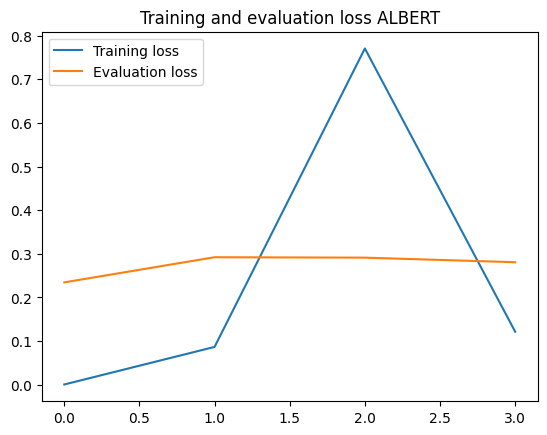

In [ ]:
# Training and evaluation loss
train_loss = albert_history['train_loss']
eval_loss = albert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss ALBERT')
plt.legend()

In [ ]:
# Evaluate model on test set
albert_result, albert_model_outputs, albert_wrong_predictions = albert_model.eval_model(test_df_scraped, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/7 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make prediction and add them to test dataset
albert_predicted, albert_predicted_probs = albert_model.predict(test_df_scraped['text'].tolist())
test_df_scraped['ALBERT_pred'] = albert_predicted

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df_scraped.head(10)

,text,topic_name,labels,ALBERT_pred
8347,However for the courage involved in just putti...,movie,1,1
12272,fellow fans this is a friendly reminder to ple...,sports,2,2
2670,Im honestly surprised and appalled that so man...,book,0,0
6975,Finally the third woman is a mistress who beco...,book,0,0
7765,The only way to get a more accurate understand...,movie,1,1
14109,I predicted the killer from the getgo and was ...,book,0,0
11584,The back of the DVD describes Diamonds of the ...,movie,1,1
7129,hard to explain but we really did savor moment...,sports,2,1
6631,But Amitabh realizes that Tabus father is much...,movie,1,2
15851,I wanted to personally slap her midway through...,book,0,0


In [ ]:
# Result of the ALBERT model on the train_test_split
print(classification_report(test_df_scraped['labels'], test_df_scraped['ALBERT_pred'], target_names=['books', 'movies', 'sports']))

              precision    recall  f1-score   support

       books       0.98      0.94      0.96      1310
      movies       0.92      0.95      0.94      1311
      sports       0.96      0.97      0.97      1311

    accuracy                           0.95      3932
   macro avg       0.95      0.95      0.95      3932
weighted avg       0.95      0.95      0.95      3932



##### MPNet

In [ ]:
print("Initializing MPNet model...")
print(f"Number of training samples: {len(train_df_scraped)}")
print(f"Number of validation samples: {len(eval_df_scraped)}")
print(f"Number of test samples: {len(test_df_scraped)}")
print("starting model training...")

_, mpnet_history = mpnet_model.train_model(
    train_df_scraped,
    eval_df=eval_df_scraped,
)

Initializing MPNet model...
Number of training samples: 15724
Number of validation samples: 1750
Number of test samples: 3932
starting model training...


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


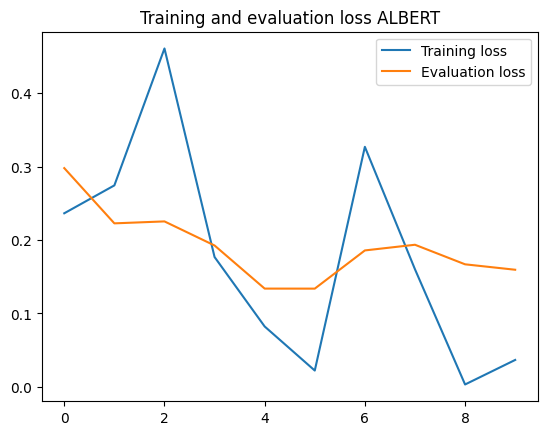

In [ ]:
# Training and evaluation loss
train_loss = mpnet_history['train_loss']
eval_loss = mpnet_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss ALBERT')
plt.legend()

In [ ]:
# evaluate the results
mpnet_results, mpnet_model_ouptuts, mpnet_wrong_predictions = mpnet_model.eval_model(test_df_scraped, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/7 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make predictions
mpnet_predicted, mpnet_predicted_probs = mpnet_model.predict(test_df_scraped['text'].tolist())
test_df_scraped['MPNet_pred'] = mpnet_predicted

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df_scraped.head(10)

,text,topic_name,labels,ALBERT_pred,MPNet_pred
8347,However for the courage involved in just putti...,movie,1,1,0
12272,fellow fans this is a friendly reminder to ple...,sports,2,2,2
2670,Im honestly surprised and appalled that so man...,book,0,0,0
6975,Finally the third woman is a mistress who beco...,book,0,0,0
7765,The only way to get a more accurate understand...,movie,1,1,1
14109,I predicted the killer from the getgo and was ...,book,0,0,1
11584,The back of the DVD describes Diamonds of the ...,movie,1,1,1
7129,hard to explain but we really did savor moment...,sports,2,1,1
6631,But Amitabh realizes that Tabus father is much...,movie,1,2,1
15851,I wanted to personally slap her midway through...,book,0,0,0


In [ ]:
# print end results
mpnet_results

{'mcc': np.float64(0.9401699544843615),
 'acc': 0.9600712105798576,
 'eval_loss': 0.15815130076030406}

In [ ]:
# classification report
print(classification_report(test_df_scraped['labels'], test_df_scraped['MPNet_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.95      0.97      0.96      1310
       movie       0.95      0.93      0.94      1311
      sports       0.97      0.98      0.98      1311

    accuracy                           0.96      3932
   macro avg       0.96      0.96      0.96      3932
weighted avg       0.96      0.96      0.96      3932



##### BERT

In [ ]:
print("Initializing BERT model...")
print(f"Number of training samples: {len(train_df_scraped)}")
print(f"Number of validation samples: {len(eval_df_scraped)}")
print(f"Number of test samples: {len(test_df_scraped)}")
print("starting model training...")

_, bert_history = bert_model.train_model(
    train_df_scraped,
    eval_df=eval_df_scraped,
)

Initializing BERT model...
Number of training samples: 15724
Number of validation samples: 1750
Number of test samples: 3932
starting model training...


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


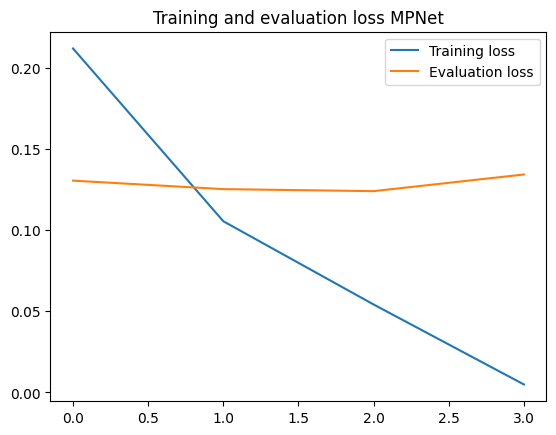

In [ ]:
# Training and evaluation loss
train_loss = bert_history['train_loss']
eval_loss = bert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss MPNet')
plt.legend()

In [ ]:
# Evaluate
bert_results, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(test_df_scraped, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/7 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make predictions and add them to test_df
bert_predictions, bert_predicted_probs = bert_model.predict(test_df_scraped['text'].tolist())
test_df_scraped['BERT_pred'] = bert_predictions

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df_scraped.head()

,text,topic_name,labels,ALBERT_pred,MPNet_pred,BERT_pred
8347,However for the courage involved in just putti...,movie,1,1,0,0
12272,fellow fans this is a friendly reminder to ple...,sports,2,2,2,2
2670,Im honestly surprised and appalled that so man...,book,0,0,0,0
6975,Finally the third woman is a mistress who beco...,book,0,0,0,0
7765,The only way to get a more accurate understand...,movie,1,1,1,1


In [ ]:
print(classification_report(test_df_scraped['labels'], test_df_scraped['BERT_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.92      0.97      0.95      1310
       movie       0.97      0.91      0.94      1311
      sports       0.99      1.00      1.00      1311

    accuracy                           0.96      3932
   macro avg       0.96      0.96      0.96      3932
weighted avg       0.96      0.96      0.96      3932



##### DistilBERT

In [ ]:
print("Initializing DistilBERT model...")
print(f"Number of training samples: {len(train_df_scraped)}")
print(f"Number of validation samples: {len(eval_df_scraped)}")
print(f"Number of test samples: {len(test_df_scraped)}")
print("starting model training...")

_, distilbert_history = distilbert_model.train_model(
    train_df_scraped,
    eval_df=eval_df_scraped,
)

Initializing DistilBERT model...
Number of training samples: 15724
Number of validation samples: 1750
Number of test samples: 3932
starting model training...


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/443 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


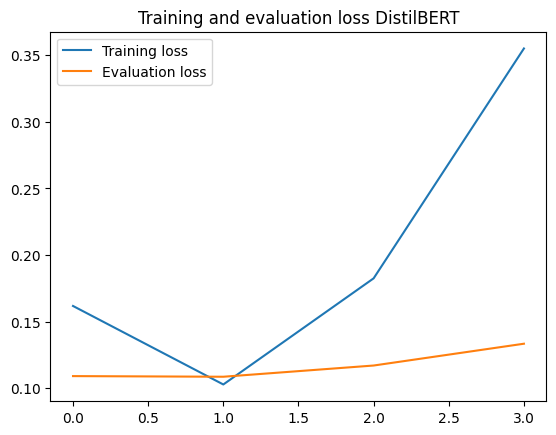

In [ ]:
# plot
train_loss = distilbert_history['train_loss']
eval_loss = distilbert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss DistilBERT')
plt.legend()

In [ ]:
# evaluate on test_df
distilbert_results, distilbert_model_outputs, distilbert_wrong_predictions = distilbert_model.eval_model(test_df_scraped, acc=sklearn.metrics.accuracy_score)

  0%|          | 0/7 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# make predictions
distilbert_predictions, distilbert_predicted_probs = distilbert_model.predict(test_df_scraped['text'].tolist())
test_df_scraped['DistilBERT_pred'] = distilbert_predictions

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
test_df_scraped.head()

,text,topic_name,labels,ALBERT_pred,MPNet_pred,BERT_pred,DistilBERT_pred
8347,However for the courage involved in just putti...,movie,1,1,0,0,1
12272,fellow fans this is a friendly reminder to ple...,sports,2,2,2,2,2
2670,Im honestly surprised and appalled that so man...,book,0,0,0,0,0
6975,Finally the third woman is a mistress who beco...,book,0,0,0,0,0
7765,The only way to get a more accurate understand...,movie,1,1,1,1,1


In [ ]:
# show results
distilbert_results

{'mcc': np.float64(0.9608012454138124),
 'acc': 0.9738046795523907,
 'eval_loss': 0.10355567953329746}

In [ ]:
# classification report
print(classification_report(test_df_scraped['labels'], test_df_scraped['DistilBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

              precision    recall  f1-score   support

        book       0.99      0.98      0.98      1310
       movie       0.95      0.98      0.96      1311
      sports       0.99      0.96      0.97      1311

    accuracy                           0.97      3932
   macro avg       0.97      0.97      0.97      3932
weighted avg       0.97      0.97      0.97      3932



#### Retrained performance

In [ ]:
final_test_df_scraped = pd.read_csv(test_path, sep='\t')
# final_test_df_scraped.head()

,sentence_id,sentence,sentiment,topic
0,0,The stadium was alive with the roar of the cro...,positive,sports
1,1,That last-minute goal had me jumping out of my...,positive,sports
2,2,I couldn’t put the book down; it swept me into...,positive,book
3,3,"The story had its moments, though some parts f...",neutral,book
4,4,"I enjoyed the way the timelines shifted, even ...",neutral,book


In [ ]:
final_test_df_scraped['labels'] = le.fit_transform(final_test_df['topic'])
final_test_df_scraped = final_test_df_scraped.rename(columns={'sentence': 'text'})
final_test_df_scraped.head()

,sentence_id,text,sentiment,topic,labels
0,0,The stadium was alive with the roar of the cro...,positive,sports,2
1,1,That last-minute goal had me jumping out of my...,positive,sports,2
2,2,I couldn’t put the book down; it swept me into...,positive,book,0
3,3,"The story had its moments, though some parts f...",neutral,book,0
4,4,"I enjoyed the way the timelines shifted, even ...",neutral,book,0


In [ ]:
# Clean the sentences using the same regex as before
final_test_df_scraped['text'] = [re.sub(r'[^a-zA-Z0-9\s]', '', text) for text in final_test_df_scraped['text']]
final_test_df_scraped.head()

,sentence_id,text,sentiment,topic,labels
0,0,The stadium was alive with the roar of the cro...,positive,sports,2
1,1,That lastminute goal had me jumping out of my ...,positive,sports,2
2,2,I couldnt put the book down it swept me into a...,positive,book,0
3,3,The story had its moments though some parts fe...,neutral,book,0
4,4,I enjoyed the way the timelines shifted even i...,neutral,book,0


In [ ]:
# Evaluate for all models
albert_results, albert_model_outputs, albert_wrong_predictions = albert_model.eval_model(final_test_df_scraped, acc=sklearn.metrics.accuracy_score)
mpnet_results, mpnet_model_ouptuts, mpnet_wrong_predictions = mpnet_model.eval_model(final_test_df_scraped, acc=sklearn.metrics.accuracy_score)
bert_results, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(final_test_df_scraped, acc=sklearn.metrics.accuracy_score)
distilbert_results, distilbert_model_outputs, distilbert_wrong_predictions = distilbert_model.eval_model(final_test_df_scraped, acc=sklearn.metrics.accuracy_score)

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# Make predictions and add them to the final_test_df
albert_predictions, albert_predicted_probs = albert_model.predict(final_test_df_scraped['text'].tolist())
final_test_df_scraped['ALBERT_pred'] = albert_predictions

mpnet_predictions, mpnet_predicted_probs = mpnet_model.predict(final_test_df_scraped['text'].tolist())
final_test_df_scraped['MPNet_pred'] = mpnet_predictions

bert_predictions, bert_predicted_probs = bert_model.predict(final_test_df_scraped['text'].tolist())
final_test_df_scraped['BERT_pred'] = bert_predictions

distilbert_predictions, distilbert_predicted_probs = distilbert_model.predict(final_test_df_scraped['text'].tolist())
final_test_df_scraped['DistilBERT_pred'] = distilbert_predictions

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
final_test_df_scraped.head(20)

,sentence_id,text,sentiment,topic,labels,ALBERT_pred,MPNet_pred,BERT_pred,DistilBERT_pred
0,0,The stadium was alive with the roar of the cro...,positive,sports,2,2,2,1,2
1,1,That lastminute goal had me jumping out of my ...,positive,sports,2,2,2,2,2
2,2,I couldnt put the book down it swept me into a...,positive,book,0,0,0,0,0
3,3,The story had its moments though some parts fe...,neutral,book,0,0,0,0,0
4,4,I enjoyed the way the timelines shifted even i...,neutral,book,0,0,0,0,0
5,5,Every time I watch this movie I notice somethi...,positive,movie,1,1,1,1,1
6,6,The movie was a wild ride from start to finish...,positive,movie,1,1,1,1,1
7,7,Honestly the team just fell apart in the secon...,negative,sports,2,2,2,1,2
8,8,No surprise therethe coach rested a few player...,neutral,sports,2,2,2,1,2
9,9,The trailer was decent giving you a taste with...,neutral,movie,1,1,1,1,1


In [ ]:
print(f"results for bert: {bert_results}")
print(f"results for albert: {albert_results}")
print(f"results for mpnet: {mpnet_results}")
print(f"results for distilbert: {distilbert_results}")

results for bert: {'mcc': np.float64(0.45899254602157846), 'acc': 0.6111111111111112, 'eval_loss': 1.0354082584381104}
results for albert: {'mcc': np.float64(0.9209401941068135), 'acc': 0.9444444444444444, 'eval_loss': 0.457114577293396}
results for mpnet: {'mcc': np.float64(0.9209401941068135), 'acc': 0.9444444444444444, 'eval_loss': 0.26818403601646423}
results for distilbert: {'mcc': np.float64(0.9209401941068135), 'acc': 0.9444444444444444, 'eval_loss': 0.4258250594139099}


In [ ]:
print("ALBERT")
print(classification_report(final_test_df_scraped['labels'], final_test_df_scraped['ALBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

print("MPNet")
print(classification_report(final_test_df_scraped['labels'], final_test_df_scraped['MPNet_pred'], target_names = ['book', 'movie', 'sports'] ))

print("BERT")
print(classification_report(final_test_df_scraped['labels'], final_test_df_scraped['BERT_pred'], target_names = ['book', 'movie', 'sports'] ))

print("DistilBERT")
print(classification_report(final_test_df_scraped['labels'], final_test_df_scraped['DistilBERT_pred'], target_names = ['book', 'movie', 'sports'] ))

ALBERT
              precision    recall  f1-score   support

        book       0.86      1.00      0.92         6
       movie       1.00      0.83      0.91         6
      sports       1.00      1.00      1.00         6

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18

MPNet
              precision    recall  f1-score   support

        book       0.86      1.00      0.92         6
       movie       1.00      0.83      0.91         6
      sports       1.00      1.00      1.00         6

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18

BERT
              precision    recall  f1-score   support

        book       0.75      1.00      0.86         6
       movie       0.44      0.67      0.53         6
      sports       1.00      0.17      0.29         6

  

## Graphs

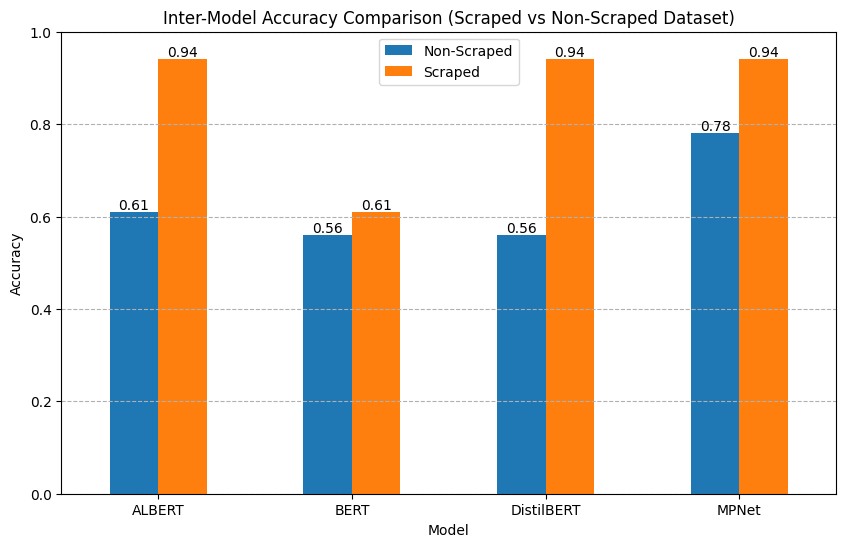

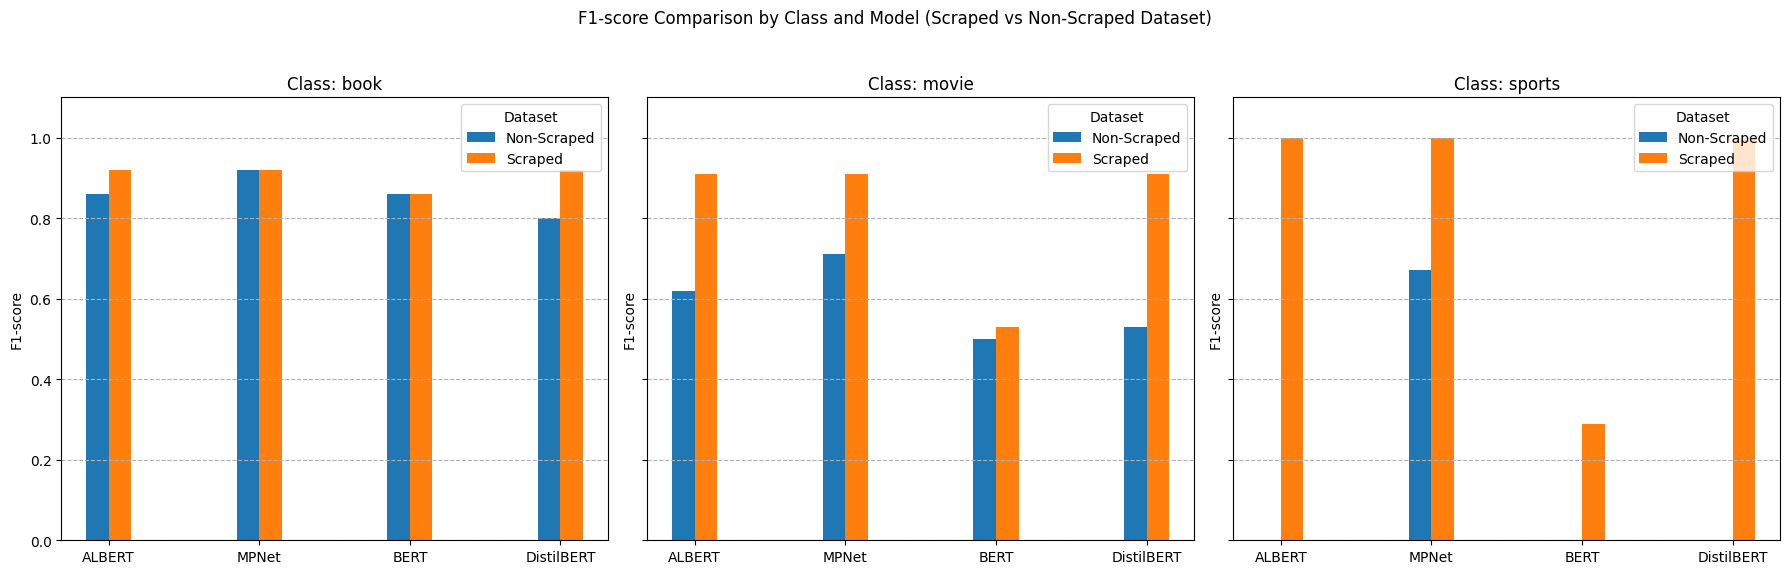

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for non-scraped dataset
data_non_scraped = {
    'Model': ['ALBERT', 'ALBERT', 'ALBERT', 'MPNet', 'MPNet', 'MPNet', 'BERT', 'BERT', 'BERT', 'DistilBERT', 'DistilBERT', 'DistilBERT'],
    'Class': ['book', 'movie', 'sports', 'book', 'movie', 'sports', 'book', 'movie', 'sports', 'book', 'movie', 'sports'],
    'Precision': [0.75, 0.50, 0.00, 0.86, 0.62, 1.00, 0.75, 0.40, 0.00, 0.67, 0.44, 0.00],
    'Recall': [1.00, 0.83, 0.00, 1.00, 0.83, 0.50, 1.00, 0.67, 0.00, 1.00, 0.67, 0.00],
    'F1-score': [0.86, 0.62, 0.00, 0.92, 0.71, 0.67, 0.86, 0.50, 0.00, 0.80, 0.53, 0.00],
    'Accuracy': [0.61, 0.61, 0.61, 0.78, 0.78, 0.78, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56] # Repeated for each class row
}
df_non_scraped = pd.DataFrame(data_non_scraped)

# Data for scraped dataset
data_scraped = {
    'Model': ['ALBERT', 'ALBERT', 'ALBERT', 'MPNet', 'MPNet', 'MPNet', 'BERT', 'BERT', 'BERT', 'DistilBERT', 'DistilBERT', 'DistilBERT'],
    'Class': ['book', 'movie', 'sports', 'book', 'movie', 'sports', 'book', 'movie', 'sports', 'book', 'movie', 'sports'],
    'Precision': [0.86, 1.00, 1.00, 0.86, 1.00, 1.00, 0.75, 0.44, 1.00, 0.86, 1.00, 1.00],
    'Recall': [1.00, 0.83, 1.00, 1.00, 0.83, 1.00, 1.00, 0.67, 0.17, 1.00, 0.83, 1.00],
    'F1-score': [0.92, 0.91, 1.00, 0.92, 0.91, 1.00, 0.86, 0.53, 0.29, 0.92, 0.91, 1.00],
    'Accuracy': [0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.61, 0.61, 0.61, 0.94, 0.94, 0.94] # Repeated for each class row
}
df_scraped = pd.DataFrame(data_scraped)


# --- Create the graphs ---

# Graph 1: Inter-model Accuracy Comparison

# Get unique accuracies for each model in both datasets
accuracy_data = {
    'Non-Scraped': df_non_scraped.groupby('Model')['Accuracy'].mean(),
    'Scraped': df_scraped.groupby('Model')['Accuracy'].mean()
}
df_accuracy = pd.DataFrame(accuracy_data)

ax = df_accuracy.plot(kind='bar', figsize=(10, 6))
plt.title('Inter-Model Accuracy Comparison (Scraped vs Non-Scraped Dataset)')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.ylim(0, 1.0) # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--')

# Add accuracy values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

# Graph 2: Inter-model F1-score Comparison by Class

# Melt the dataframes to make it easier for plotting
df_non_scraped_melted = df_non_scraped.melt(id_vars=['Model', 'Class'], value_vars=['F1-score'], var_name='Metric', value_name='Score')
df_scraped_melted = df_scraped.melt(id_vars=['Model', 'Class'], value_vars=['F1-score'], var_name='Metric', value_name='Score')

# Combine melted dataframes and add a 'Dataset' column
df_non_scraped_melted['Dataset'] = 'Non-Scraped'
df_scraped_melted['Dataset'] = 'Scraped'
df_combined_f1 = pd.concat([df_non_scraped_melted, df_scraped_melted])

# Plotting using pandas grouped bar chart
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
fig.suptitle('F1-score Comparison by Class and Model (Scraped vs Non-Scraped Dataset)')

classes = df_combined_f1['Class'].unique()
models = df_combined_f1['Model'].unique()
datasets = df_combined_f1['Dataset'].unique()

bar_width = 0.15
x = np.arange(len(models))

for i, class_name in enumerate(classes):
    ax = axes[i]
    class_data = df_combined_f1[df_combined_f1['Class'] == class_name]

    for j, dataset_name in enumerate(datasets):
        dataset_data = class_data[class_data['Dataset'] == dataset_name]
        scores = [dataset_data[dataset_data['Model'] == model]['Score'].iloc[0] for model in models]
        ax.bar(x + j * bar_width, scores, bar_width, label=dataset_name)

    ax.set_title(f'Class: {class_name}')
    ax.set_xticks(x + bar_width * (len(datasets) - 1) / 2)
    ax.set_xticklabels(models)
    ax.set_ylabel('F1-score')
    ax.set_ylim(0, 1.1) # F1-score is between 0 and 1
    ax.grid(axis='y', linestyle='--')
    ax.legend(title='Dataset')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

Citations